#Spectral clustering for MINST dataset - Version 0.0# 
$N$: number of data points

$K$: number of clusters


##Road Map##
1. Input data and label
2. Compute similarity matrix $M$ with some kernel (say, Gaussian kernel), apply some thereshold to get adjacency matrix $W$
3. Compute the Laplacian matrix $L=D-W$ of the graph (every node represents one data point)
4. Find the eigenvectors corresponding to the $K$ minimal eigenvalues of $L$ and construct matrix $H$ ($N$ × $K$)
5. Apply K-means algrithm to classify rows of $H$

In [45]:
# Test block
a = [1,2,3,4]
b = [1,1,1,2]
np.exp(-1.6)

0.20189651799465538

In [46]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import random

In [47]:
X, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True)
print(X.shape, y.shape)

(70000, 784) (70000,)


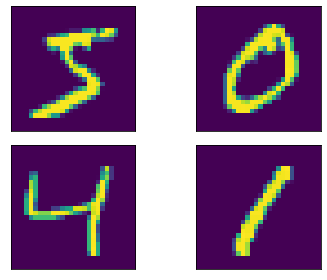

In [48]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex='all', sharey='all')
ax = ax.flatten()
for i in range(4):
    img = X[i].reshape(28, 28)
    # ax[i].imshow(img,cmap='Greys')
    ax[i].imshow(img)
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [73]:
N = 300
K = 10
X = X[0:N,:]
y = y[0:N]
print(X.shape,y.shape)

(300, 784) (300,)


In [146]:
def Adjacency_GaussianKernel(X):
  W = np.zeros([N,N])
  M = np.zeros([N,N])
  epsilon = 0.3
  gamma = 1e-7
  for i in range(N):
    for j in range(N):
      temp = np.inner( (X[i,:]-X[j,:]), (X[i,:]-X[j,:]) )
      #M[i,j] = np.exp(-gamma*temp)
      W[i,j] = np.exp(-gamma*temp)
      #if M[i,j]>epsilon:
      #  W[i,j] = 1
  return W,M

def Laplacian(X):
  D = np.zeros([N,N])
  W,M = Adjacency_GaussianKernel(X)
  for i in range(N):
    for j in range(N):
      D[i,i] = D[i,i]+W[i,j]
  L = D - W
  return D,L

def H_constrcution(X):
  H = np.zeros([K,N])
  D,L = Laplacian(X)
  eigenValues, eigenVectors = np.linalg.eig(L)
  idx = eigenValues.argsort()[::1]
  eigenValues = eigenValues[idx]
  eigenVectors = eigenVectors[:,idx]
  for i in range(K):
    H[i] = eigenVectors[i]
  H = H.T
  return H

In [147]:
def K_means_clustering_standard_SED(X,K):
    """
    Performs K-means-clustering with standard squared Euclidean distance
    Input : X : dataset (N : number samples x m : size of data/element)
            K : numbers of clusters  
    output : centroids : list with 
    centroids : list of element
    clusters : list of list of the indexes of each cluster 
    """
    
    N=len(X)
    random.seed(1000) #since we use random, we are going to set a seed,... not necessary
    centroids_index = random.sample(range(N), K)#Initialize centroids
    centroids=X[centroids_index]
    clusters = asign_clusters(centroids,X,K) #asign to cluster
    new_centroids=update_centroids(clusters,X,K) 

    number_it=1
    while loss(centroids,clusters,X,K)!= loss(new_centroids,asign_clusters(new_centroids,X,K),X,K): #while the centroids change, then (1) is improving by construction , we can also use > instead
        centroids=new_centroids.copy() #copy, python basic = to copy isn't enougth
        clusters = asign_clusters(centroids,X,K) #asign to cluster
        new_centroids=update_centroids(clusters, X,K)
        number_it +=1

    
    print("Iterations numbers " + str(number_it))

    return centroids


def loss(centroids,clusters,X,K):
    """
    Calculate loss : with squared euclidean distance
    Input : 
            centroids and clusters to compute loss from
            X : dataset 
            K : numbers of clusters  
    output : squared euclidean distance : L(X,k)=sum sum || Xi - Cl ||^2
    """
    loss=0
    for l in range(K):
        for i in clusters[l]:
            loss+=np.inner(X[i]-centroids[l],X[i]-centroids[l])
    return loss

def update_centroids(clusters, X,K):
    """
    update the new centroids computing the mean on clusters 
    """
    new_centroids=[]#placeholder
    for l in range(K):
        new_centroids.append(sommer(X[clusters[l]])/len(clusters[l]) ) #sommer is a function that compute the vector sum of a list of vectors
    return new_centroids

def asign_clusters(centroids,X,K): 
    """
    For each centroids, we asign each element of X in it's corresponding cluster
    We do the argmin of the standard squared euclidian norm 
    """
    clusters=[[] for i in range(K)] #placeholder
    for i in range(len(X)): 
        sed=[np.inner(X[i]-centroids[j],X[i]-centroids[j]) for j in range(K)] #for each element xi of X, sed is the distance from each centroids
        clusters[np.argmin(sed)].append(i)
    return clusters


def sommer(list_of_list):
    """
    Compute the vector sum of a list of vectors
    """
    Somme= [0]*len(list_of_list[0]) #placeholder, nul vector
    for i in range(len(list_of_list)):
        Somme=np.add(list_of_list[i],Somme)
    return Somme

In [148]:
# Do K-means clustering
H = H_constrcution(X)
print(H.shape)
centroids = K_means_clustering_standard_SED(H,K)
clusters = asign_clusters(centroids,H,K) #cluster result

(300, 10)
Iterations numbers 25


In [149]:
#Compute the accuracy of the clustering

def accuracy(cluster,y,K):
  """
  computes the accuracy of of the cluster
  input : clusters indexes, y : true labels 

  return accuracy : A =sum_k |{i ∈ Ck : i = mk}/number of elements
  """
  acc=0
  card=0
  
  for l in range(K):
    #find the mk : most frequent digit of cluster l
    mk= most_freq_digit(y[cluster[l]],K)
    print('The '+str(l+1)+'th cluster corresponds to the number '+str(mk))
    for element in y[cluster[l]]: 
      if int(element) == mk :
        acc+=1
      card +=1
  return acc/card #in fact card = len(y)


def most_freq_digit(liste,K):
  """
  find the most freq digit in liste, we suppose that liste contains int, from 0 to K-1
  """
  compteur=[0]*K #store how much time we see each element in the list
  for element in liste:
    element=int(element)
    compteur[element] += 1
  max_elem=max(compteur) 
  index=compteur.index(max_elem)
  return index

In [150]:
accuracy(clusters,y,K)

The 1th cluster corresponds to the number 0
The 2th cluster corresponds to the number 4
The 3th cluster corresponds to the number 0
The 4th cluster corresponds to the number 7
The 5th cluster corresponds to the number 3
The 6th cluster corresponds to the number 5
The 7th cluster corresponds to the number 1
The 8th cluster corresponds to the number 1
The 9th cluster corresponds to the number 6
The 10th cluster corresponds to the number 7


0.16333333333333333